# Getting started with naryn

Naryn is an implementation of a time-series database, for efficient storage, retrieval and analysis of electronic health records (EHR).

## Setup

### Install packages if needed

In [1]:
# utility functions
ON_KAGGLE <- dir.exists("/kaggle")
package_exists <- function(pkg) pkg %in% rownames(installed.packages())

In [2]:
# install naryn if needed
if (!package_exists("naryn")) {
    if (ON_KAGGLE) {
        install.packages("/kaggle/input/d/aviezerl/naryn-source-code/naryn_2.6.14_R_x86_64-pc-linux-gnu.savta", repos = NULL)
    } else {
        install.packages("naryn")
    }
}

In [3]:
# install the rest of the packages
required_packages <- c("dplyr", "purrr", "ggplot2", "survminer", "survival", "cmprsk", "pROC", "xgboost")
for (pkg in required_packages) {
    if (!package_exists(pkg)) {
        install.packages(pkg)
    }
}

### Load packages

In [4]:
library(naryn)
library(dplyr)
library(ggplot2)
theme_set(theme_classic())


Attaching package: 'naryn'


The following object is masked from 'package:base':

    months



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




### Download the example database 

Towards this vignette we are going to use a small database which was simulated to include an example of a typical EMR database. It can be downloaded from [here](https://naryn.s3.eu-west-1.amazonaws.com/naryn_example_db.tar.gz) or using the following code:

In [5]:
if (ON_KAGGLE) {
    system("cp -r /kaggle/input/simulated-ehr-dataset/sample_db /kaggle/working/")
    db_dir <- "/kaggle/working/sample_db"
    emr_db.connect(db_dir)
    emr_db.reload()
} else {
    if (!dir.exists("sample_db")) {
        emr_download_example_data()
    }
    db_dir <- "sample_db"
}

Note that although smaller than the real database, this example database is still quite large (~1.2GB) and will take a few minutes to download.

## Tracks

The basic element of Naryn is a `track` - a single numerical data element (e.g. Creatinine lab measurement) that is recorded for many patients at various time points. A track can be thought of as a very sparse two-dimensional matrix with a row for each patient in the database, and a column for each timepoint in the resolution of hours. Another way to think of a track is as a table with triplets of patient, timepoint and value: 

|id|time   |lab.CREATININE.BLOOD|
|--|-------|--------------------|
|1 |1228730|1.1803077           |
|1 |1229711|1.1490350           |
|1 |1230163|1.1682341           |
|1 |1239512|1.1314427           |
|1 |1248503|1.2582408           |
|2 |1274663|0.7628091           |
|2 |1288516|0.7240421           |
|2 |1321502|0.7352935           |
|3 |1222798|0.9173284           |
|3 |1286821|0.9149746           |

The value can be any numerical value, but it is usually a lab test result, or categorical variable representing a diagnosis. The time is a number representing the number of hours since 1/3/1867 00:00, and the id is a unique identifier for each patient which is defined in a special track called '*patients.dob*', which contains the time of birth for each patient (see below).

## Connect to database

A naryn database is a folder containing a number of tracks. To connect to a database, use the `emr_db.connect` function:

In [6]:
emr_db.connect(db_dir)

Now we can use `emr_track.ls` to list all the tracks in the database:



In [7]:
head(emr_track.ls())

[1] "dx.icd9_000" "dx.icd9_001" "dx.icd9_002" "dx.icd9_003" "dx.icd9_004"
[6] "dx.icd9_005"

show number of available tracks in database:

In [8]:
length(emr_track.ls())

[1] 2998

We can also use `emr_track.ls` to list all the tracks that match a certain pattern:



In [9]:
emr_track.ls("CREATININE")

[1] "lab.CREATININE.BLOOD" "lab.CREATININE.URINE"

> Note: Naryn supports connecting to multiple databases at the same time, by giving a vector of paths to `emr_db.connect`, see more in the 'Database' section of the [advanced vignette](https://tanaylab.github.io/naryn/articles/advanced.html).

_**Exercise:** list all the "RBC" tracks in the database_

## Extract data from tracks

We can now go back to the Creatinine example and extract the data from the track. This can be done using the `emr_extract()` function which is the 'Swiss army knife' of the package. It can be used to extract data from a single track, or from multiple tracks, while applying various filters and transformations, but we will start with the simplest example of extracting the data from a single track:

In [10]:
creatinine_df <- emr_extract("lab.CREATININE.BLOOD")
head(creatinine_df)

,id,time,ref,lab.CREATININE.BLOOD
,<int>,<int>,<int>,<dbl>
1,1,1228730,-1,1.1803077
2,1,1229711,-1,1.1490350
3,1,1230163,-1,1.1682341
4,1,1239512,-1,1.1314427
5,1,1248503,-1,1.2582408
6,2,1274663,-1,0.7628091


We can see that the data is returned as a data frame with four columns: id, time, ref and 'lab.CREATININE.BLOOD' which contains the values. The id column contains the patient id, the time column contains the time of the measurement in hours since 1/3/1867 00:00, and the value column contains the Creatinine measurement of the patient at each timepoint. 

For information regarding the ref column, see the 'Records and References' section in the [advanced vignette](https://tanaylab.github.io/naryn/articles/advanced.html).

The data frame is sorted by id and time, so that the data for each patient is consecutive. 

You can change the name of the value column using the `names` argument:

In [11]:
head(emr_extract("lab.CREATININE.BLOOD", names = "Creatinine"))

,id,time,ref,Creatinine
,<int>,<int>,<int>,<dbl>
1,1,1228730,-1,1.1803077
2,1,1229711,-1,1.1490350
3,1,1230163,-1,1.1682341
4,1,1239512,-1,1.1314427
5,1,1248503,-1,1.2582408
6,2,1274663,-1,0.7628091


### Track expression 

The first argument of `emr_extract` was, in the example above, a string representing the name of the track. However, it can also be a *track expression*, which is a string that can contain functions that will be applied to the track after extracting the data. For example, we can extract the lab value multiplied by two:

In [12]:
creatinine_df1 <- emr_extract("lab.CREATININE.BLOOD * 2", names = "Creatinine")
head(creatinine_df1)

,id,time,ref,Creatinine
,<int>,<int>,<int>,<dbl>
1,1,1228730,-1,2.360615
2,1,1229711,-1,2.298070
3,1,1230163,-1,2.336468
4,1,1239512,-1,2.262885
5,1,1248503,-1,2.516482
6,2,1274663,-1,1.525618


Note that the functions used in the track expression must be able to be applied to a vector of values and should return a vector of the same length.

_**Exercise:** Extract BMI values._

_The weight and height tracks are "LAB.WEIGHT" and "LAB.HEIGHT". Reminder: $$BMI = \frac{weight}{height^2}$$_

#### Changing time to date

We can transform the `time` field from the internal `naryn` representation to year, month day and hour using the `emr_time2date()` function:

In [13]:
creatinine_df %>%
    mutate(emr_time2date(time)) %>%
    head()

,id,time,ref,lab.CREATININE.BLOOD,day,month,year,hour
,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1228730,-1,1.1803077,3,5,2007,2
2,1,1229711,-1,1.1490350,12,6,2007,23
3,1,1230163,-1,1.1682341,1,7,2007,19
4,1,1239512,-1,1.1314427,25,7,2008,8
5,1,1248503,-1,1.2582408,3,8,2009,23
6,2,1274663,-1,0.7628091,28,7,2012,23


## Iterators and virtual tracks

In the previous example we extracted the data from a single track, what happens if we want to extract data from multiple tracks at once? For example, we want to extract both Creatinine and blood Glucose levels of patients which had Chronic Kidney Disease (CKD), 5 years before their diagnosis. In order to achieve this we need to introduce the concept of *iterators*. 

An iterator is a set of points in the *patient-time space*[^1] that defines the way in which naryn traverses the database. In the Creatinine example, the iterator was simply the set of all *patient-time* points that were included in the track, but now - we want our point-of-view to be the CKD diagnosis so we set the iterator to the track of ICD9 code 585 `dx.icd9_585`: 

In [14]:
ckd_labs <- emr_extract(c("lab.CREATININE.BLOOD", "lab.GLUCOSE.BLOOD"), iterator = "dx.icd9_585")
head(ckd_labs)
nrow(na.omit(ckd_labs))

,id,time,ref,lab.CREATININE.BLOOD,lab.GLUCOSE.BLOOD
,<int>,<int>,<int>,<dbl>,<dbl>
1,1,1238196,-1,NaN,NaN
2,1,1242854,-1,NaN,NaN
3,1,1243714,-1,NaN,NaN
4,22,1220227,-1,NaN,NaN
5,22,1224686,-1,NaN,NaN
6,22,1232399,-1,NaN,NaN


[1] 13

We can see that the "lab.CREATININE.BLOOD" and "lab.GLUCOSE.BLOOD" are all NA. This is because the iterator is set to the 
CKD diagnosis, and the Creatinine and RBC tests were not conducted at the exact time the diagnosis was recorded. In order to get the Glucose/Creatinine test that was done 5 years prior to the diagnosis, we would have to: 

1. Tell naryn to look back 5 years before the diagnosis
2. Tell naryn what to do if there is more than one Creatinine test in the 5 years prior to the diagnosis, for example - take the latest test, or more generally - tell naryn which function to apply to values of the track. 

This can be done using a *virtual track*. A virtual track is a way to tell naryn how to compute the value of a track when at a specific point in the *patient-time space*. It is created using the `emr_virtual_track()` function, which tells naryn how to shift the time for a given track (1, `time.shift`) and which function to apply to the values of the track (2, `func`). 

Note that the time shift is always in reference to the *iterator*. So for example, in our case we would like to look at Creatinine / Glucose measurement 5 years before the diagnosis. If our iterator is at the time of the CKD diagnosis, we want to look at a time window that starts 5 years before and ends at the time of diagnosis:


In [15]:
emr_vtrack.create("creatinine_5y", "lab.CREATININE.BLOOD", time.shift = c(-years(5), 0), func = "latest")
emr_vtrack.create("glucose_5y", "lab.GLUCOSE.BLOOD", time.shift = c(-years(5), 0), func = "latest")

Now, we can extract the data from the virtual tracks (instead of the tracks themselves):



In [16]:
ckd_labs <- emr_extract(c("creatinine_5y", "glucose_5y"), iterator = "dx.icd9_585", names = c("Creatinine", "Glucose"))
head(ckd_labs)

,id,time,ref,Creatinine,Glucose
,<int>,<int>,<int>,<dbl>,<dbl>
1,1,1238196,-1,1.1682341,187.19873
2,1,1242854,-1,1.1314427,120.63850
3,1,1243714,-1,1.1314427,120.63850
4,22,1220227,-1,1.3684419,99.08260
5,22,1224686,-1,0.6575883,86.04514
6,22,1232399,-1,1.1613698,94.50937


The available virtual tracks functions are listed in the `emr_vtrack.create` function documentation:

In [17]:
?emr_vtrack.create

emr_vtrack.create            package:naryn             R Documentation

_C_r_e_a_t_e_s _a _n_e_w _v_i_r_t_u_a_l _t_r_a_c_k

_D_e_s_c_r_i_p_t_i_o_n:

     Creates a new virtual track.

_U_s_a_g_e:

     emr_vtrack.create(
       vtrack,
       src,
       func = NULL,
       params = NULL,
       keepref = FALSE,
       time.shift = NULL,
       id.map = NULL,
       filter = NULL
     )
     
_A_r_g_u_m_e_n_t_s:

  vtrack: virtual track name.

     src: data source. either a track name or a list of two members:
          ID-Time Values table (see "User Manual") and a logical. If
          the logical is 'TRUE', the data in the table is treated as
          categorical, otherwise as quantitative.

func, params: see below.

 keepref: see below.

time.shift: time shift and expansion for iterator time.

  id.map: id mapping.

  filter: virtual track filter. Note that filters with a source of
          another virtual track are not allowed in order to avoid
          loops.

_D_e_t_a_i_l_s:

     This function creates a new virtual track named 'vtrack'.

     During the evaluation of track expression that contains a virtual
     track 'vtrack' the iterator point of id-time (ID1, Time, Ref) form
     is transformed first to an id-time interval: (ID2, Time1, Time2,
     Ref).

     If 'id.map' is 'NULL' then ID1 == ID2, otherwise ID2 is derived
     from the translation table provided in 'id.map'. This table is a
     data frame with two first columns named 'id1' and 'id2', where
     'id1' is mapped to 'id2'. If 'id.map' contains also a third
     optional column named 'time.shift' the value V of this column is
     used to shift the time accordingly, i.e. Time1 = Time2 = Time + V.

     'time.shift' parameter (not to be confused with 'time.shift'
     column of 'id.map') can be either a single number X, in which case
     Time1 = Time2 = Time + X. Alternatively 'time.shift' can be a
     vector of two numbers, i.e. 'c(X1, X2)', which would result in
     Time1 = Time + X1, Time2 = Time + X2.

     Both 'time.shift' parameter and 'time.shift' column within
     'id.map' may be used simultaneously. In this case the time shifts
     are applied sequentially.

     At the next step values from the data source 'src' that fall into
     the new id-time interval and pass the 'filter' are collected.
     'src' may be either a track name or a list of two members: ID-Time
     Values table (see "User Manual") and a logical. If the logical is
     'TRUE', the data in the table is treated as categorical, otherwise
     as quantitative.

     If 'keepref' is 'TRUE' the reference of these values must match
     'ref' unless either the reference or 'ref' are '-1'.

     Function 'func' (with 'params') is applied then on the collected
     values and produces a single value which is considered to be the
     value of 'vtrack' for the given iterator point. If 'NULL' is used
     as a value for 'func', 'func' is set then implicitly to 'value',
     if the data source is categorical, or 'avg', if the data source is
     quantitative.

     Use the following table for a reference of all valid functions and
     parameters combinations.

     CATEGORICAL DATA SOURCE

       FUNC                  PARAM      DESCRIPTION                                                              
       value                 vals/NULL  A source value or -1 if there is more than one.                          
       exists                vals       1 if any of the 'vals' exist otherwise 0.                                
       sample                NULL       Uniformly sampled source value.                                          
       sample.time           NULL       Time of theuniformly sampled source value.                               
                                                                                                                 
       frequent              vals/NULL  The mostfrequent sour

We would also like to know how long before the diagnosis each test was performed, so we will create an additional virtual track, this time with a function that computes the difference in time between the time of the diagnosis and the latest blood test. Also, we would like the time difference to be in the resolution of months, so we will give `emr_extract` a track expression that divides the time difference by 30 * 24 (the number of hours in a month), which is equivalent to the `month` function:

In [18]:
emr_vtrack.create("creatinine_5y_dt", "lab.CREATININE.BLOOD", time.shift = c(-years(5), 0), func = "dt2.latest")
emr_vtrack.create("glucose_5y_dt", "lab.GLUCOSE.BLOOD", time.shift = c(-years(5), 0), func = "dt2.latest")
ckd_labs <- emr_extract(
    c("creatinine_5y", "glucose_5y", "creatinine_5y_dt/month()", "glucose_5y_dt/month()"),
    iterator = "dx.icd9_585",
    names = c("Creatinine", "Glucose", "Creatinine_dt", "Glucose_dt")
)
head(ckd_labs)

,id,time,ref,Creatinine,Glucose,Creatinine_dt,Glucose_dt
,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1238196,-1,1.1682341,187.19873,11.156944,11.156944
2,1,1242854,-1,1.1314427,120.63850,4.641667,4.641667
3,1,1243714,-1,1.1314427,120.63850,5.836111,5.836111
4,22,1220227,-1,1.3684419,99.08260,3.897222,3.897222
5,22,1224686,-1,0.6575883,86.04514,3.520833,3.520833
6,22,1232399,-1,1.1613698,94.50937,2.381944,2.381944


Yay! we got what we wanted, but something is still weird - we can see that some patients (and in this sampled database - most patients) have more than one diagnosis of a CKD. Many times, this is indeed the case - a patient can be diagnosed with a disease multiple times, but more commonly in EMR data - the same diagnosis is recorded multiple times, and what we actually want is the earliest diagnosis. In order to achieve that we would have to use *filters*.

[^1]: Actually, *patient-time-reference* space, but this is explained in the advanced vignette.

_**Exercise:** Extract the earliest WBC values 5 years before the diagnosis of CKD._ 

## Filters

A *filter* is a logical condition that is applied to the *iterator* in order to decide which points to include and which to exclude. In our case we want to include only the earliest diagnosis of CKD, so we use the `emr_filter.create` function to create a filter that excludes all patient-time points that had already have a diagnosis of CKD at an earlier time:

In [19]:
emr_filter.create("ckd_in_past", "dx.icd9_585", time.shift = c(-years(120), -1))

We will now apply the filter to our query: 



In [20]:
ckd_labs <- emr_extract(
    c("creatinine_5y", "glucose_5y", "creatinine_5y_dt/month()", "glucose_5y_dt/month()"),
    iterator = "dx.icd9_585",
    names = c("Creatinine", "Glucose", "Creatinine_dt", "Glucose_dt"),
    filter = "!ckd_in_past"
)

head(ckd_labs)

,id,time,ref,Creatinine,Glucose,Creatinine_dt,Glucose_dt
,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1238196,-1,1.1682341,187.19873,11.1569444,11.1569444
2,22,1220227,-1,1.3684419,99.08260,3.8972222,3.8972222
3,40,1232253,-1,0.6094497,104.90481,0.1375000,0.1375000
4,44,1228184,-1,0.8192249,104.22690,0.1958333,0.1958333
5,45,1336104,-1,0.6837639,91.92958,1.9472222,1.9472222
6,48,1346088,-1,1.0116725,79.19666,0.1472222,0.1472222


Voila! every patient now has only the earliest diagnosis of CKD. 

_**Exercise:** Create a filter that includes only patients that will have CKD in the **future**._ 

### Value filters 

In addition to requiring that a data point exists in the *patient-time space* (like the previous example), filters may also be used to require specific value restrictions. For example, we can create a filter that includes only points where the latest 5-year Glucose was abnormal (say, above 100):

In [21]:
emr_filter.create("abnormal_glucose", "glucose_5y", val = 100, operator = ">")
ckd_labs_abnormal_glucose <- emr_extract(
    c("creatinine_5y", "glucose_5y", "creatinine_5y_dt/month()", "glucose_5y_dt/month()"),
    iterator = "dx.icd9_585",
    filter = "!ckd_in_past & abnormal_glucose",
    names = c("Creatinine", "Glucose", "Creatinine_dt", "Glucose_dt")
)
head(ckd_labs_abnormal_glucose)

,id,time,ref,Creatinine,Glucose,Creatinine_dt,Glucose_dt
,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1238196,-1,1.1682341,187.1987,11.1569444,11.1569444
2,40,1232253,-1,0.6094497,104.9048,0.1375000,0.1375000
3,44,1228184,-1,0.8192249,104.2269,0.1958333,0.1958333
4,49,1251046,-1,0.8509813,172.4313,2.8875000,2.8875000
5,54,1226343,-1,0.8735216,106.0885,0.5750000,0.5750000
6,66,1280729,-1,1.1531183,102.9670,0.9986111,0.9986111


Another example is to include or exclude based on the value of a categorical track. For example, in order to include only patients that were diagnosed with stage iv of CKD (ICD9 code 585.4) we filter "dx.icd9_585" to include only points with value of "14" (see note below). As the source for this filter is the same as our iterator, the time.shift used is the default c(0,0) which means it interrogates the same *patient-time-reference* data point.

In [22]:
emr_filter.create("severe", "dx.icd9_585", val = 14)
ckd_severe <- emr_extract(
    c("creatinine_5y", "glucose_5y", "dx.icd9_585"),
    iterator = "dx.icd9_585",
    filter = "!ckd_in_past & severe",
    names = c("Creatinine", "Glucose", "icd9_585")
)
head(ckd_severe)

,id,time,ref,Creatinine,Glucose,icd9_585
,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,48,1346088,-1,1.0116725,79.19666,14
2,248,1249382,-1,0.8124868,97.05019,14
3,731,1220842,-1,0.7290940,95.97245,14
4,777,1356208,-1,0.7595837,119.17236,14
5,795,1223712,-1,0.8867609,134.69302,14
6,1542,1336426,-1,0.5827906,101.12039,14


> NOTE: since ICD9 diagnosis codes have a tree like structure, and X.0, X.00 are both valid codes and must be distinguishable, the diagnosis tracks all include a prefix of 1 for the minor code, so X.0 will be translated to icd9_X and a value of 10 will be stored instead of 0.

_**Exercise:** Extract the creatinine and glucose values for patients with severe CKD **and** 5-year latest creatinine above 1.5_

## Time range

Until now we learned how to use filters to exclude or include datapoints by their value or existence, but what if we want to include only points that are within a certain time range? 

For example, in many EHR databases the diagnoses in the beginning of the database do not reflect the actual time the diagnosis was given, or we know that there was a change in the standard care at a certain year. In such cases we can use the `stime` and `etime` arguments which limit the query to points that are between the given start and end times: 

In [23]:
ckd_df <- emr_extract(
    c("creatinine_5y", "glucose_5y", "dx.icd9_585"),
    iterator = "dx.icd9_585",
    names = c("Creatinine", "Glucose", "icd9_585"),
    stime = emr_date2time(1, 1, 2008),
    etime = emr_date2time(1, 1, 2022),
)
head(ckd_df)

,id,time,ref,Creatinine,Glucose,icd9_585
,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,1,1238196,-1,1.1682341,187.1987,19
2,1,1242854,-1,1.1314427,120.6385,19
3,1,1243714,-1,1.1314427,120.6385,19
4,22,1245888,-1,1.1887014,113.7356,1
5,22,1249244,-1,0.8253483,117.8263,1
6,40,1259205,-1,0.9233058,103.2491,19


_**Exercise:** Extract all the RBC test results that were conducted in 2011_

## Define virtual tracks for age and sex

Patient *age* is an important factor in most settings. For example, say that we want to know the age of a patient at the time of their first diagnosis of CKD. We can do this by creating a virtual track that computes the difference in time between the time of the diagnosis (iterator time) and the time of birth (as defined in track 'patients.dob'). 

We set the name of the virtual track to 'age' and define the source for the virtual track to 'patients.dob'. At each point of the iterator, we want to look backward in time as much as necessary (say - 120 years) and compute the time difference between the time of birth and the current time, so we set the `time.shift` to `c(-years(120), 0)` and the function to `dt2.earliest` (delta time between the iterator + time.shift[2] and time of earliest appearance of 'patients.dob'):

In [24]:
emr_vtrack.create("age", "patients.dob", time.shift = c(-years(120), 0), func = "dt2.earliest")

We can now extract the age of the patient at the time of their first diagnosis of CKD in the resolution of years: 

In [25]:
age_at_ckd_diag <- emr_extract("age/year()", iterator = "dx.icd9_585", filter = "!ckd_in_past", name = "age")
head(age_at_ckd_diag)

,id,time,ref,age
,<int>,<int>,<int>,<dbl>
1,1,1238196,-1,80.15959
2,22,1220227,-1,85.69441
3,40,1232253,-1,47.95297
4,44,1228184,-1,78.52557
5,45,1336104,-1,62.29361
6,48,1346088,-1,87.84555


Sex can be defined in a similar way going backward in time and taking the earliest **value** at the "patients.dob" track:



In [26]:
emr_vtrack.create("sex", "patients.dob", time.shift = c(-years(120), 0), func = "earliest")

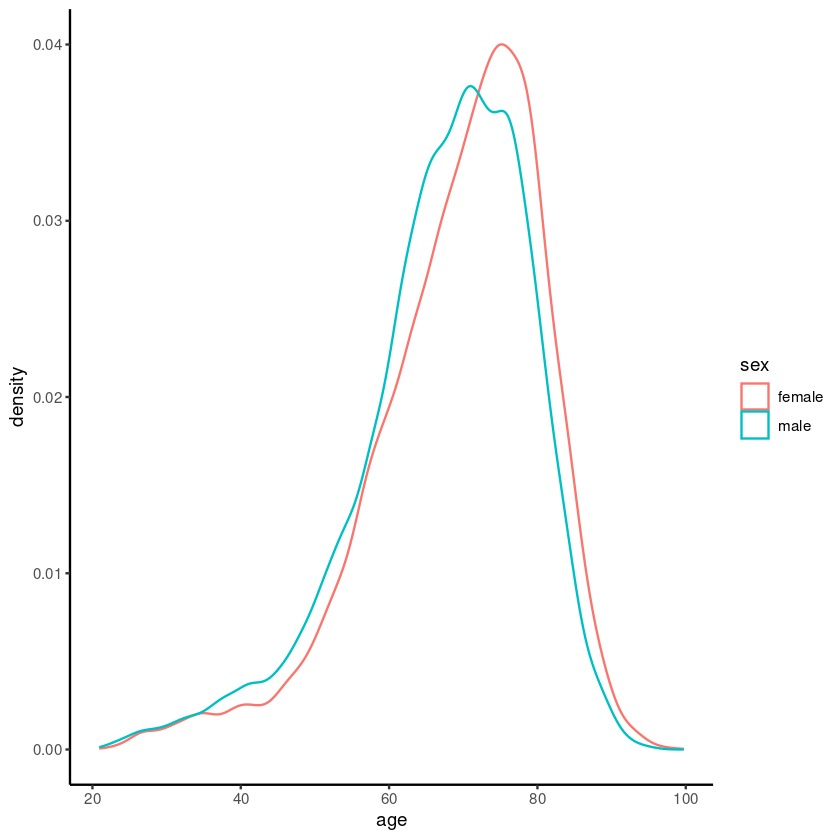

In [27]:
emr_extract(c("age/year()", "sex"), iterator = "dx.icd9_585", name = c("age", "sex")) %>%
    mutate(sex = c("male", "female")[sex]) %>%
    ggplot(aes(x = age, color = sex, group = sex)) +
    geom_density()

In a similar way we can define filters for patient status, including the fact that patient was born, has died, has registered to the EMR or has left for good: 

In [28]:
emr_filter.create("born", "patients.dob", time.shift = c(-120, 0) * year())
emr_filter.create("dead", "patients.dod", time.shift = c(-120, 0) * year())
emr_filter.create("registered", "patients.status.register", time.shift = c(-120, 0) * year())
emr_filter.create("left_for_good", "patients.status.lfg", time.shift = c(-120, 0) * year())

We can use the same approach to define a virtual track for the onset of CKD instead of using the filter we defined above: 

In [29]:
emr_vtrack.create("disease_onset", "dx.icd9_585", time.shift = c(0, 120) * year(), func = "earliest.time")

And finally, we can define a filter for the fact that the patient will have the disease in the future:

In [30]:
emr_filter.create("will_have_disease", "dx.icd9_585", time.shift = c(0, 120) * year())

## Incidence rate

Next, we want to compute the incidence rate of CKD, for each age and sex. The formula for incidence rate is: 

$$ (New Cases_{a,s}) / (Population_{a,s} x Timeframe) $$

$$a = age, s = sex$$

The formula may appear straightforward, but it can be challenging to implement in traditional databases, particularly when computing the denominator, which requires counting the age and sex of all patients in the system across time. An alternative approach, known as the "index-date" method, is often used, in which the calculation is performed only for patients at a specific point in time, rather than the entire database. This approach can result in a small number of cases, making it difficult to stratify the computation based on age and sex.

So how can we use `naryn` to compute this?

#### The enumerator 

We need to count the new cases of CKD in each age group and sex. To do that we will use the function `emr_dist` which can compute the distributions of values of a track. 

`emr_dist` accepts pairs of track expression and breaks, and counts the number of values in each strata, so we can ask it to count the numbers of disease onsets in each age and sex. 

In [31]:
age_breaks <- seq(35, 85, by = 5)
stime <- emr_date2time(1, 1, 2008) # taking 3 years of history
etime <- emr_date2time(1, 1, 2022) # end of db

disease_count <- emr_dist(
    "age/year()",
    age_breaks,
    "sex",
    NULL,
    iterator = "dx.icd9_585",
    filter = "!ckd_in_past",
    right = FALSE,
    dataframe = TRUE,
    names = c("age", "sex"),
    stime = stime,
    etime = etime
) %>% rename(n_sick = n)
tail(disease_count)

,age,sex,n_sick
,<fct>,<fct>,<dbl>
15,"[55,60)",2,166
16,"[60,65)",2,225
17,"[65,70)",2,302
18,"[70,75)",2,307
19,"[75,80)",2,317
20,"[80,85)",2,193


- Note again that we used the `"!ckd_in_past"` filter in order to make sure that we are going over the *onset* of CKD and not only diagnosis. 

- For sex, we set the breaks to "NULL" in order to implicitly use the possible values of the track. 

#### The denominator 

In order to calculate the denominator, we have to sum the 'man-months' we have in the system. To do that we  use another type of iterator called `beat iterator`. A beat iterator goes over all the patient in the system every "time beat", for example, in our case, every month. 

We have to count only patients that did not have the disease yet (but may to get it in the future):

In [32]:
emr_filter.create("has_disease", "dx.icd9_585", time.shift = c(-120, 0) * year())

In addition, we count only patients that were born, didn't die yet and are currently registered to the system. This would be enforced using filter parameter. 

In [33]:
full_pop <- emr_dist(
    "age/year()",
    age_breaks,
    "sex",
    NULL,
    iterator = month(),
    filter = "born & !dead & registered & !left_for_good & !has_disease",
    right = FALSE,
    dataframe = TRUE,
    names = c("age", "sex"),
    stime = stime,
    etime = etime
) %>%
    rename(man_months = n)
head(full_pop)

,age,sex,man_months
,<fct>,<fct>,<dbl>
1,"[35,40)",1,905124
2,"[40,45)",1,723567
3,"[45,50)",1,602136
4,"[50,55)",1,545987
5,"[55,60)",1,502793
6,"[60,65)",1,409923


#### Computing incidence rate

Now that we have both the enumerator and the denominator we can compute the incidence rate per 100k:

In [34]:
incidence <- disease_count %>%
    full_join(full_pop, by = c("age", "sex")) %>%
    mutate(
        p = n_sick / man_months,
        incidence = p * 12 * 1e5,
        lower_ci = floor(1000 * (p - qnorm(0.975) * sqrt(p * (1 - p) / man_months)) * 12 * 1e5) / 1000,
        upper_ci = floor(1000 * (p + qnorm(0.975) * sqrt(p * (1 - p) / man_months)) * 12 * 1e5) / 1000,
        sex = factor(c("male", "female")[sex])
    )

head(incidence)

,age,sex,n_sick,man_months,p,incidence,lower_ci,upper_ci
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,"[35,40)",male,42,905124,0.00004640248,55.68298,38.843,72.522
2,"[40,45)",male,59,723567,0.00008154048,97.84858,72.882,122.815
3,"[45,50)",male,121,602136,0.00020095128,241.14154,198.179,284.103
4,"[50,55)",male,191,545987,0.00034982518,419.79021,360.266,479.313
5,"[55,60)",male,270,502793,0.00053700032,644.40038,567.557,721.243
6,"[60,65)",male,416,409923,0.00101482474,1217.78968,1100.825,1334.753


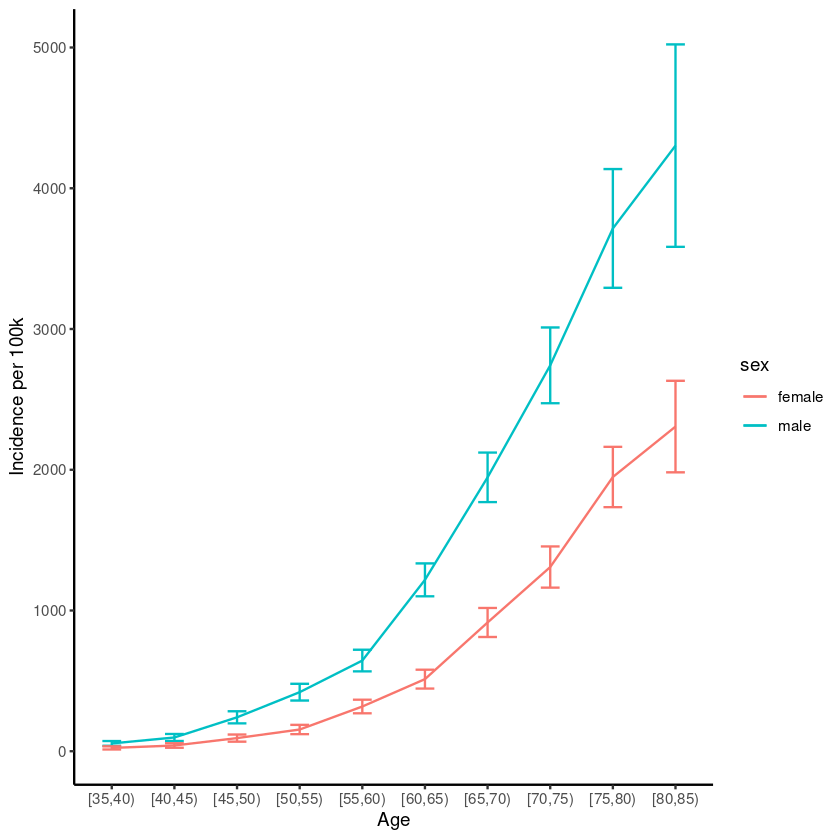

In [35]:
incidence %>%
    ggplot(aes(x = age, y = incidence, ymin = lower_ci, ymax = upper_ci, group = sex, color = sex)) +
    geom_line() +
    ylab("Incidence per 100k") +
    xlab("Age") +
    geom_errorbar(width = 0.3)

_**Exercise:** Compute the incidence rate of diabetes ("dx.250")_

## Survival analysis

Next, we want to estimate the survival of CKD patients between the ages of 60 and 65 (not inclusive). We have a track called "patients.dod" which indicates the death of patients. We will start by computing the time from the disease diagnosis to death:

In [36]:
# create a filter for male patients (val=1) between ages 60 to 65 (time.shift=c(-65, -60))
emr_filter.create("male_60_65", "patients.dob", time.shift = c(-65, -60) * year(), val = 1)

In [37]:
emr_vtrack.create("survival", "patients.dod", time.shift = c(0, 120) * 365 * 24, func = "dt1.earliest")
disease_survival <- emr_extract(c("age/year()", "sex", "survival"),
    iterator = "dx.icd9_585",
    stime = stime, etime = etime,
    filter = "!ckd_in_past & male_60_65",
    names = c("age", "sex", "survival")
)
head(disease_survival)

,id,time,ref,age,sex,survival
,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,829,1237761,-1,62.57123,1,32535
2,905,1351491,-1,60.31564,1,NaN
3,909,1355931,-1,63.82740,1,NaN
4,918,1313958,-1,62.82637,1,NaN
5,1063,1238104,-1,64.44532,1,52352
6,1064,1324502,-1,61.09795,1,NaN


> NOTE: Survival analysis is very sensitive to patient age and sex. This is why for this example we focus on males age 60-65.

The `NA` values indicate that the patient did not die yet. 

We now need to compute the survival of the "background" patients. We want to go over all the patients at ages 60-65, and compute their time until death ("survival" virtual track). To do that we can use an `extended beat iterator`, which, as its name suggests, is a variation on the beat iterator which aligns the beat to a set of points. In our case we will align the points on their time of birth ("patients.dob") and add the number of years for each patient (e.g. 60) to extract the data at each patient's birthday. 

We will use the same filters we used in the incidence rate analysis above.

In [38]:
gen_pop_survival <- purrr::map_df(60:64, ~
    emr_extract(
        c("age/year()", "sex", "survival"),
        iterator = list(.x * year(), "patients.dob"),
        stime = stime, etime = etime,
        filter = "!has_disease & born & !dead & registered & !left_for_good & male_60_65",
        names = c("age", "sex", "survival")
    ))

We prefer not to use a patient twice (in different ages):

In [39]:
gen_pop_survival <- gen_pop_survival %>%
    sample_n(n()) %>%
    distinct(id, .keep_all = T)
head(gen_pop_survival)

,id,time,ref,age,sex,survival
,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,77859,1297753,-1,63,1,NaN
2,99055,1288478,-1,62,1,NaN
3,77661,1331320,-1,62,1,NaN
4,3628,1279684,-1,63,1,17972
5,6932,1312206,-1,64,1,NaN
6,30695,1345150,-1,63,1,NaN


We can now compute the Kaplan-Meier survival curve. 

We will start by combining the two data frames and reshape it to the format of the survival function. Note that we apply censoring to reflect the latest update of the database which was at Jan 1, 2021:

In [40]:
survival <- disease_survival %>%
    mutate(cohort = "disease") %>%
    bind_rows(gen_pop_survival %>% mutate(cohort = "general pop")) %>%
    mutate(
        follow_time = ifelse(!is.na(survival), survival, (emr_date2time(1, 1, 2021) - time)),
        status = ifelse(is.na(survival), 0, 1)
    ) %>%
    mutate(follow_time = follow_time / year())
head(survival)

,id,time,ref,age,sex,survival,cohort,follow_time,status
,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,829,1237761,-1,62.57123,1,32535,disease,3.7140411,1
2,905,1351491,-1,60.31564,1,NaN,disease,-0.3373288,0
3,909,1355931,-1,63.82740,1,NaN,disease,-0.8441781,0
4,918,1313958,-1,62.82637,1,NaN,disease,3.9472603,0
5,1063,1238104,-1,64.44532,1,52352,disease,5.9762557,1
6,1064,1324502,-1,61.09795,1,NaN,disease,2.7436073,0


We can now use `survminer` and `survival` packages to compute and plot the Kaplan-Meier curves:

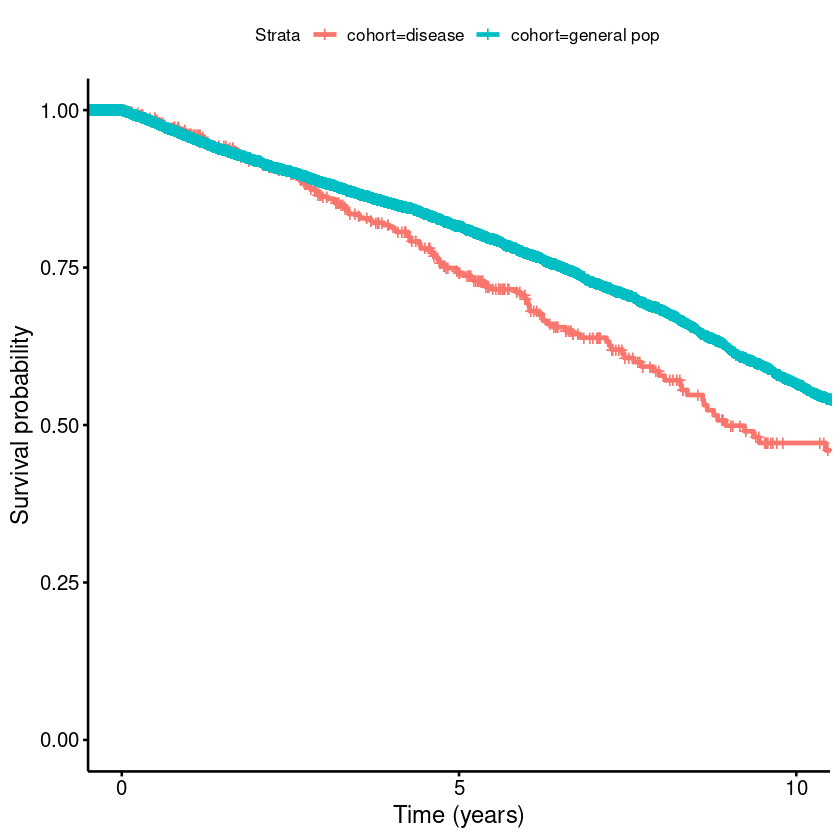

In [41]:
fit <- survminer::surv_fit(survival::Surv(follow_time, status) ~ cohort, data = survival)
survminer::ggsurvplot(fit, data = survival, xlab = "Time (years)", xlim = c(0, 10))

_**Exercise:** Plot the Kaplan-Meier of diabetes survival in age 55-60 ("dx.250")_

## Time to outcome

Another type of analysis we can do is to compute the distribution of time to outcome. Say, for example, that we want to check if patients with high Creatinine levels are more likely to be diagnosed with CKD. We will again focus our analysis on ages 60-65, taking into account the change in incidence rate of CKD as a function of age. 

We will start by extracting the high and low creatinine tests. We will do it using `emr_screen` which instead of extracting the information from a track expression, returns the patient+time points that satisfy a condition:

In [42]:
creat_high <- emr_screen("lab.CREATININE.BLOOD > 1.5", filter = "!has_disease") %>% distinct(id, .keep_all = TRUE)
creat_low <- emr_screen("lab.CREATININE.BLOOD < 1", filter = "!has_disease") %>% distinct(id, .keep_all = TRUE)
head(creat_high)
head(creat_low)

,id,time,ref
,<int>,<int>,<int>
1,3,1289599,-1
2,44,1220005,-1
3,48,1308254,-1
4,67,1303339,-1
5,85,1224583,-1
6,88,1280548,-1


,id,time,ref
,<int>,<int>,<int>
1,2,1274663,-1
2,3,1222798,-1
3,4,1227786,-1
4,5,1241062,-1
5,6,1231928,-1
6,7,1321047,-1


In [43]:
cohort <- creat_high %>%
    mutate(cohort = "creatinine_high") %>%
    bind_rows(creat_low %>% mutate(cohort = "creatinine_low"))
head(cohort)

,id,time,ref,cohort
,<int>,<int>,<int>,<chr>
1,3,1289599,-1,creatinine_high
2,44,1220005,-1,creatinine_high
3,48,1308254,-1,creatinine_high
4,67,1303339,-1,creatinine_high
5,85,1224583,-1,creatinine_high
6,88,1280548,-1,creatinine_high


We will now define a virtual track which will compute the time from the current iterator to the onset of the disease and extract it for every Creatinine lab test:

In [44]:
emr_filter.create("age_60_65", "patients.dob", time.shift = c(-65, -60) * year())
emr_vtrack.create(
    "time_to_disease",
    "dx.icd9_585",
    time.shift = c(0, 120) * year(),
    func = "dt1.earliest",
    filter = "!ckd_in_past"
)
time_to_outcome <- emr_extract(
    c("age/year()", "sex", "survival", "time_to_disease"),
    iterator = cohort,
    stime = stime, etime = etime,
    filter = "age_60_65",
    names = c("age", "sex", "survival", "time_to_disease")
)
head(time_to_outcome)

,id,time,ref,age,sex,survival,time_to_disease
,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,108,1301176,-1,64.73927,1,NaN,NaN
2,147,1256784,-1,61.31598,2,NaN,NaN
3,241,1288244,-1,62.48208,1,66292,NaN
4,270,1237191,-1,63.57169,1,64065,52042
5,343,1234633,-1,63.85514,2,NaN,NaN
6,480,1243402,-1,61.02443,1,103934,64839


We will encode the event of CKD as `1` and the event of death as `2`:

In [45]:
time_to_outcome <- time_to_outcome %>%
    mutate(
        follow_time = ifelse(!is.na(survival), survival, (emr_date2time(1, 1, 2021) - time)),
        follow_time = ifelse(!is.na(time_to_disease), time_to_disease, follow_time),
        status = ifelse(!is.na(time_to_disease), 1, ifelse(!is.na(survival), 2, 0))
    ) %>%
    mutate(follow_time = follow_time / year()) %>%
    inner_join(cohort %>% select(id, time, cohort), by = c("id", "time"))
head(time_to_outcome)

,id,time,ref,age,sex,survival,time_to_disease,follow_time,status,cohort
,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,108,1301176,-1,64.73927,1,NaN,NaN,5.406393,0,creatinine_high
2,147,1256784,-1,61.31598,2,NaN,NaN,10.473973,0,creatinine_low
3,241,1288244,-1,62.48208,1,66292,NaN,7.567580,2,creatinine_high
4,270,1237191,-1,63.57169,1,64065,52042,5.940868,1,creatinine_high
5,343,1234633,-1,63.85514,2,NaN,NaN,13.002626,0,creatinine_low
6,480,1243402,-1,61.02443,1,103934,64839,7.401712,1,creatinine_low


We can now fit and plot a model with a competing risk of death which compares the probability for CKD for high and low Creatinine values:

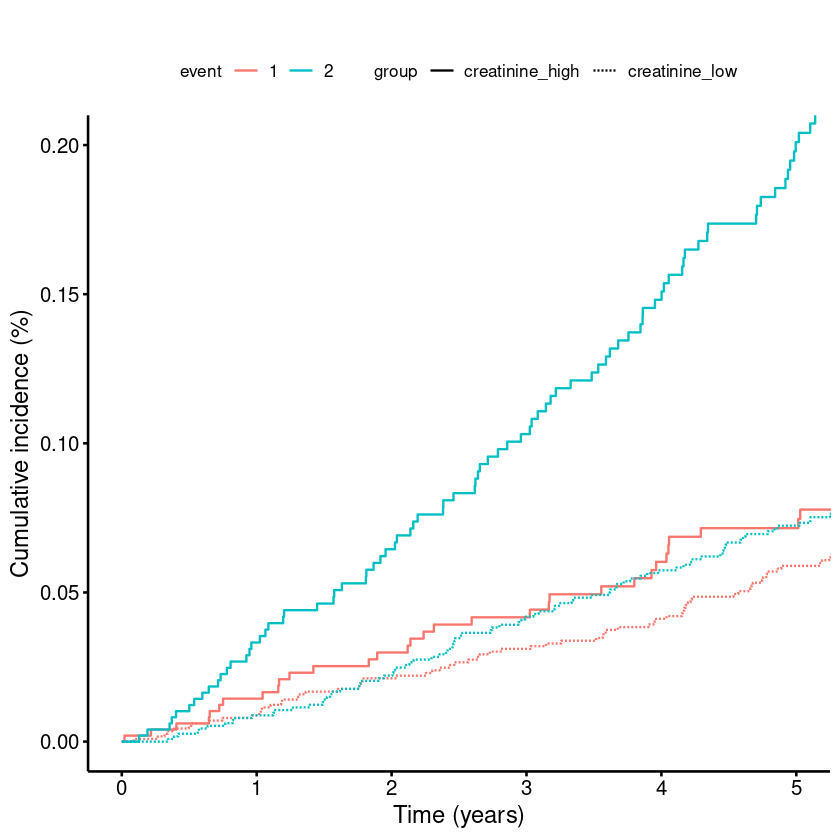

In [46]:
fit <- cmprsk::cuminc(time_to_outcome$follow_time, time_to_outcome$status, group = time_to_outcome$cohort)
survminer::ggcompetingrisks(
    fit = fit,
    multiple_panels = FALSE,
    main = "",
    xlab = "Time (years)",
    ylab = "Cumulative incidence (%)",
    xlim = c(0, 5),
    ylim = c(0, 0.2)
)

_**Exercise:** Repeat the above analysis to check if patients with high glucose values (>100) have a higher chance to be diagnosed with CKD_

## Building a CKD predictor

Now that we looked at the data a bit, we would like to create a 1-year prediction model for CKD. The model will take into account the age and sex of the patient along with lab test measurements sampled between 5 years and 1 years prior to diagnosis.

#### Sample controls

One of the important decisions when building a predictor is defining the control. Minimally, we probably need to sample patients that are similar on age and sex, but many times we might want to enforce other covariates such as the lack of a disease or number of available tests. 

For this example, we sample control based on age, sex, and the calendaric year. The calendaric year is important in many cases as standard care / distribution of the population changes over time.

We will compute the distribution of age, sex and calendaric year for the patients who had the disease, and then sample control using this distribution:

In [47]:
disease <- emr_extract("dx.icd9_585", filter = "!ckd_in_past")
cohort_dist <- emr_dist(
    "age/year()",
    20:90,
    "sex",
    NULL,
    "emr_time2year(EMR_TIME)",
    2008:2022,
    iterator = disease,
    names = c("age", "sex", "year"),
    dataframe = TRUE,
    right = FALSE
) %>%
    mutate(
        age = (20:90)[as.numeric(age)], # convert age and year from factor to numeric
        year = (2008:2022)[as.numeric(year)]
    ) %>%
    filter(n > 0)
head(cohort_dist)

,age,sex,year,n
,<int>,<fct>,<int>,<dbl>
1,20,1,2008,1
2,23,1,2008,1
3,25,1,2008,1
4,26,1,2008,1
5,31,1,2008,1
6,32,1,2008,2


Go over each each combination of age, sex and calendaric year and sample patients:

In [48]:
exclude_patients <- disease$id
cf <- 1
control <- data.frame(id = c(), time = c())

# go over each combination of age, sex and calendaric year
for (i in 1:nrow(cohort_dist)) {
    # exclude the patients with the disease and those that we already selected
    emr_filter.create("fexclude_patients", data.frame(id = exclude_patients, time = emr_date2time(1, 1, 2002)), time.shift = c(-120, 120) * year())

    # create a filter for the current sex and age
    emr_filter.create("fsex_age", "patients.dob", time.shift = c(-cohort_dist$age[i] - 1, -cohort_dist$age[i]) * year(), val = as.numeric(cohort_dist$sex[i]))

    # extract patients at the given age and sex
    pool <- emr_extract("sex",
        iterator = cohort_dist$age[i] * year(), # this basically says - take only a single point at the current age
        filter = "fsex_age & !fexclude_patients",
        stime = emr_date2time(1, 1, cohort_dist$year[i]),
        etime = emr_date2time(1, 1, cohort_dist$year[i] + 1)
    )

    # sample patients+time and add to the control
    control <- rbind(control, pool %>% sample_n(cohort_dist$n[i] * cf))

    exclude_patients <- c(disease$id, control$id)
    emr_filter.rm("fexclude_patients")
    emr_filter.rm("fsex_age")
}

In [49]:
head(control)

,id,time,ref,sex
,<int>,<int>,<int>,<dbl>
1,42919,1234560,-1,1
2,39738,1234560,-1,1
3,58252,1234560,-1,1
4,56329,1234560,-1,1
5,80419,1234560,-1,1
6,34696,1234560,-1,1


#### Extract the data

Now we can extract the features for the disease and control patient+time points. We would extract all the labs in the sampled database:

In [50]:
labs <- emr_track.ls("^lab.")
length(labs)
head(labs)

[1] 96

[1] "lab.ALBUMIN"           "lab.ALBUM_CREAT.RATIO" "lab.ALT"              
[4] "lab.AMYLASE.BLOOD"     "lab.APTT.sec"          "lab.APTTR"

Create for every lab a virtual track which would sample a value (if exists) 5 years prior to the current iterator:

In [51]:
purrr::walk(labs, ~ emr_vtrack.create(paste0("v_", .x), .x, time.shift = c(-5, -1) * year(), func = "sample"))

Combine the disease and control to a single data frame:

In [52]:
options(emr_max.data.size = 1e09)
target <- disease %>%
    select(id, time) %>%
    mutate(class = 1) %>%
    bind_rows(control %>% select(id, time) %>% mutate(class = 0))
head(target)

,id,time,class
,<int>,<int>,<dbl>
1,1,1238196,1
2,22,1220227,1
3,40,1232253,1
4,44,1228184,1
5,45,1336104,1
6,48,1346088,1


Extract the labs data + age and sex:

In [53]:
data <- emr_extract(c("age/year()", "sex", paste0("v_", labs)), iterator = target, names = c("age", "sex", labs))
head(data)

,id,time,ref,age,sex,lab.ALBUMIN,lab.ALBUM_CREAT.RATIO,lab.ALT,lab.AMYLASE.BLOOD,lab.APTT.sec,⋯,lab.SPECIFIC_GRAVITY,lab.T3,lab.T4,lab.TRANSFERRIN,lab.TRIGLYCERIDES,lab.TSH,lab.UREA.BLOOD,lab.URIC_ACID.BLOOD,lab.WBC,lab.WEIGHT
,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1238196,-1,80.15959,1,4.605492,18.90564,19.31131,93.61308,35.44086,⋯,1.024822,4.223889,NaN,236.9867,105.1252,3.005530,43.00790,6.096089,9.600314,40.59161
2,22,1220227,-1,85.69441,1,NaN,NaN,NaN,NaN,NaN,⋯,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,40,1232253,-1,47.95297,2,4.106202,21.46503,10.02673,27.10096,30.61352,⋯,1.024999,3.523762,14.69115,265.9865,108.7473,3.672915,32.98265,4.400000,7.571088,34.62907
4,44,1228184,-1,78.52557,1,NaN,NaN,NaN,NaN,NaN,⋯,1.025021,NaN,14.99849,NaN,NaN,5.034045,NaN,NaN,NaN,NaN
5,45,1336104,-1,62.29361,2,4.095174,NaN,13.91433,106.54393,32.72647,⋯,NaN,NaN,14.69523,NaN,129.2534,3.113750,33.75704,5.224836,7.800000,40.63680
6,48,1346088,-1,87.84555,2,3.576982,18.02866,10.01721,91.83642,34.44077,⋯,1.013204,4.300000,13.42368,153.2631,183.6200,4.412379,38.00212,6.909094,6.200532,31.87110


#### Separate to train and test

We will now separate our data to train and test, while maintaining age and sex:

In [54]:
train_test <- data %>%
    select(id, age, sex) %>%
    inner_join(target %>% select(id, class), by = "id") %>%
    mutate(age = cut(age, seq(20, 90, by = 5), right = FALSE, include.lowest = TRUE)) %>%
    group_by(age, sex, class) %>%
    mutate(train = runif(n()) < 0.8) %>%
    ungroup()
head(train_test)

id,age,sex,class,train
<int>,<fct>,<dbl>,<dbl>,<lgl>
1,"[80,85)",1,1,FALSE
22,"[85,90]",1,1,TRUE
40,"[45,50)",2,1,TRUE
44,"[75,80)",1,1,TRUE
45,"[60,65)",2,1,TRUE
48,"[85,90]",2,1,TRUE


#### Run a XGBoost predictor

In [55]:
target <- train_test
features <- train_test %>%
    select(id) %>%
    left_join(data) %>%
    select(-id, -time, -ref)

library(xgboost)
train_y <- target[target$train, ]
test_y <- target[!target$train, ]

train_x <- as.matrix(features[target$train, ])
test_x <- as.matrix(features[!target$train, ])

xgb_train <- xgb.DMatrix(data = train_x, label = train_y$class)
xgb_test <- xgb.DMatrix(data = test_x, label = test_y$class)

watchlist <- list(train = xgb_train, test = xgb_test)

# fit XGBoost model and display training and testing data at each round
model <- xgb.train(
    data = xgb_train,
    booster = "gbtree",
    objective = "binary:logistic",
    max.depth = 3,
    subsample = 0.5,
    eta = 0.07,
    min_child_weight = 1,
    gamma = 0,
    eval_metric = "auc",
    watchlist = watchlist,
    nrounds = 100
)
model

Joining, by = "id"

Attaching package: 'xgboost'


The following object is masked from 'package:dplyr':

    slice




[1]	train-auc:0.612663	test-auc:0.596593 
[2]	train-auc:0.626648	test-auc:0.589582 
[3]	train-auc:0.639704	test-auc:0.606413 
[4]	train-auc:0.645340	test-auc:0.613366 
[5]	train-auc:0.651984	test-auc:0.615757 
[6]	train-auc:0.657413	test-auc:0.617871 
[7]	train-auc:0.661878	test-auc:0.618203 
[8]	train-auc:0.663027	test-auc:0.618981 
[9]	train-auc:0.663816	test-auc:0.619343 
[10]	train-auc:0.665409	test-auc:0.618070 
[11]	train-auc:0.668131	test-auc:0.616047 
[12]	train-auc:0.669319	test-auc:0.613970 
[13]	train-auc:0.671677	test-auc:0.616717 
[14]	train-auc:0.673911	test-auc:0.617515 
[15]	train-auc:0.677131	test-auc:0.618886 
[16]	train-auc:0.679338	test-auc:0.617803 
[17]	train-auc:0.680691	test-auc:0.618348 
[18]	train-auc:0.681704	test-auc:0.617566 
[19]	train-auc:0.683362	test-auc:0.616845 
[20]	train-auc:0.684162	test-auc:0.616689 
[21]	train-auc:0.685245	test-auc:0.617829 
[22]	train-auc:0.686011	test-auc:0.617706 
[23]	train-auc:0.687834	test-auc:0.619044 
[24]	train-auc:0.689

##### xgb.Booster
raw: 116.9 Kb 
call:
  xgb.train(data = xgb_train, nrounds = 100, watchlist = watchlist, 
    booster = "gbtree", objective = "binary:logistic", max.depth = 3, 
    subsample = 0.5, eta = 0.07, min_child_weight = 1, gamma = 0, 
    eval_metric = "auc")
params (as set within xgb.train):
  booster = "gbtree", objective = "binary:logistic", max_depth = "3", subsample = "0.5", eta = "0.07", min_child_weight = "1", gamma = "0", eval_metric = "auc", validate_parameters = "TRUE"
xgb.attributes:
  niter
callbacks:
  cb.print.evaluation(period = print_every_n)
  cb.evaluation.log()
# of features: 98 
niter: 100
nfeatures : 98 
evaluation_log:
    iter train_auc  test_auc
       1 0.6126630 0.5965929
       2 0.6266480 0.5895816
---                         
      99 0.7574427 0.6239012
     100 0.7582369 0.6239789

#### Evaluate the model

Predict the test data:

In [56]:
test <- test_y %>% mutate(pred_score = predict(model, test_x))

Calculate ROC:

Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.default(response = test$class, predictor = test$pred_score,     ci = TRUE, plot = TRUE, smoothed = TRUE, ci.alpha = 0.9,     stratified = FALSE, auc.polygon = TRUE, max.auc.polygon = TRUE,     grid = TRUE, print.auc = TRUE, show.thres = TRUE)

Data: test$pred_score in 861 controls (test$class 0) < 1210 cases (test$class 1).
Area under the curve: 0.624
95% CI: 0.5997-0.6482 (DeLong)

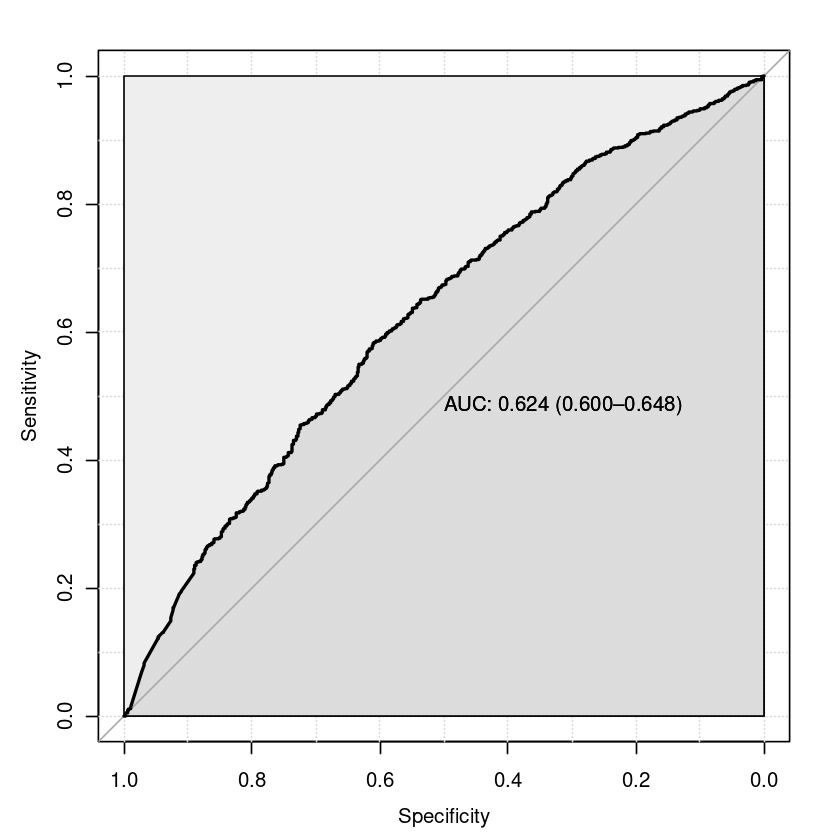

In [57]:
pROC_obj <- pROC::roc(test$class, test$pred_score,
    smoothed = TRUE,
    # arguments for ci
    ci = TRUE, ci.alpha = 0.9, stratified = FALSE,
    # arguments for plot
    plot = TRUE, auc.polygon = TRUE, max.auc.polygon = TRUE, grid = TRUE,
    print.auc = TRUE, show.thres = TRUE
)
pROC_obj

Plot the score difference between the classes:

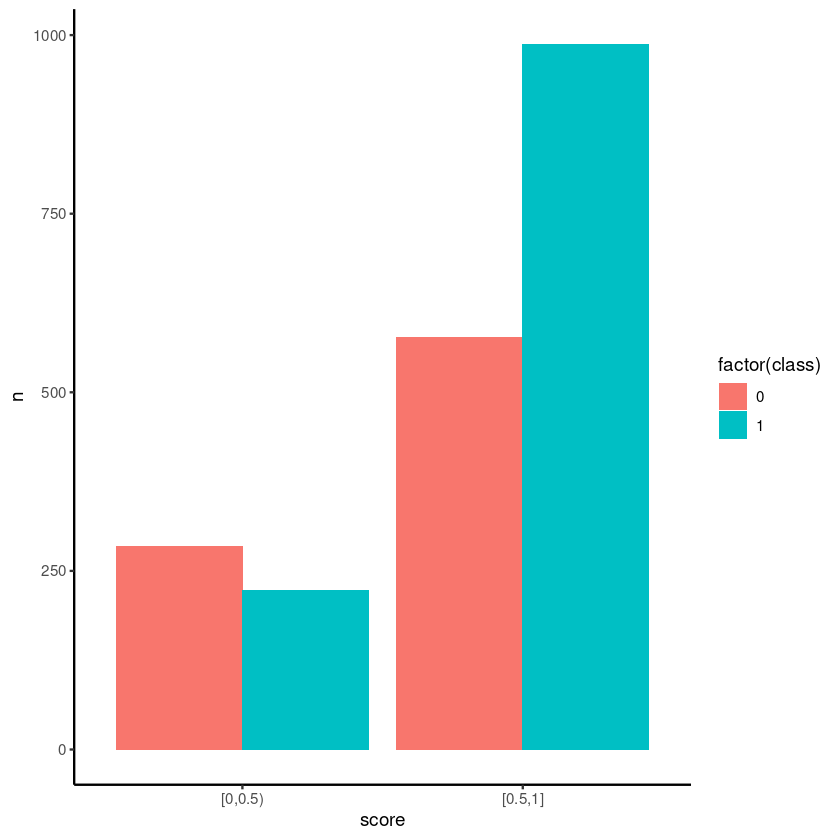

In [58]:
test %>%
    mutate(score = cut(pred_score, c(0, 0.5, 1), right = FALSE, include.lowest = T)) %>%
    count(class, score) %>%
    ggplot(aes(x = score, y = n, fill = factor(class))) +
    geom_bar(stat = "identity", position = "dodge")

_**Exercise:** Build a predictor for diabetes (dx.250)_

## Additional examples

In the next few sections we will present a few additional examples of how to use `naryn` for analysis of EMR data. It is recommended to try and implement a solution to each example before looking at the code below it. 

### Extract survival time for patients with pancreatic cancer

Extract the survival time (time until death) for patients with pancreatic cancer (ICD9 code 157.9):

Define a filter for just Pancreatic cancer in the 157 icd9 code:

In [59]:
emr_filter.create("pancreatic_cancer", "dx.icd9_157", val = 19)

Define a filter for previous pancreatic cancer (sometime in the past):



In [60]:
emr_filter.create("pancreatic_cancer_in_past", "dx.icd9_157", val = 19, time.shift = c(-years(120), -1))

To find the first diagnosis of pancreatic cancer we will go over all 157 diagnosis, filter out those that are not pancreatic cancer and make sure there wasn't a prior diagnosis of pancreatic cancer:



In [61]:
pancreatic_cancer_survival <- emr_extract("survival", iterator = "dx.icd9_157", filter = "pancreatic_cancer & !pancreatic_cancer_in_past")
nrow(pancreatic_cancer_survival)
head(pancreatic_cancer_survival)

[1] 25

,id,time,ref,survival
,<int>,<int>,<int>,<dbl>
1,12192,1256866,-1,19910
2,17022,1311645,-1,NaN
3,24217,1309964,-1,14332
4,27971,1280769,-1,3927
5,28135,1263030,-1,23106
6,34252,1341200,-1,9016


Note that NA in survival means that the patient still has not died.

We can now compute the Kaplan-Meier survival curve for pancreatic cancer patients. 
Censoring is applied to reflect latest update of database (Jan 6, 2022):


In [62]:
pancreatic_cancer_survival <- pancreatic_cancer_survival %>%
    mutate(
        follow_time = ifelse(!is.na(survival), survival, emr_date2time(6, 1, 2022) - time),
        status = ifelse(is.na(survival), 0, 1)
    ) %>%
    mutate(follow_time = follow_time / month())

Fit the survival curve: 



Loading required package: ggpubr


Attaching package: 'survival'


The following object is masked from 'package:survminer':

    myeloma




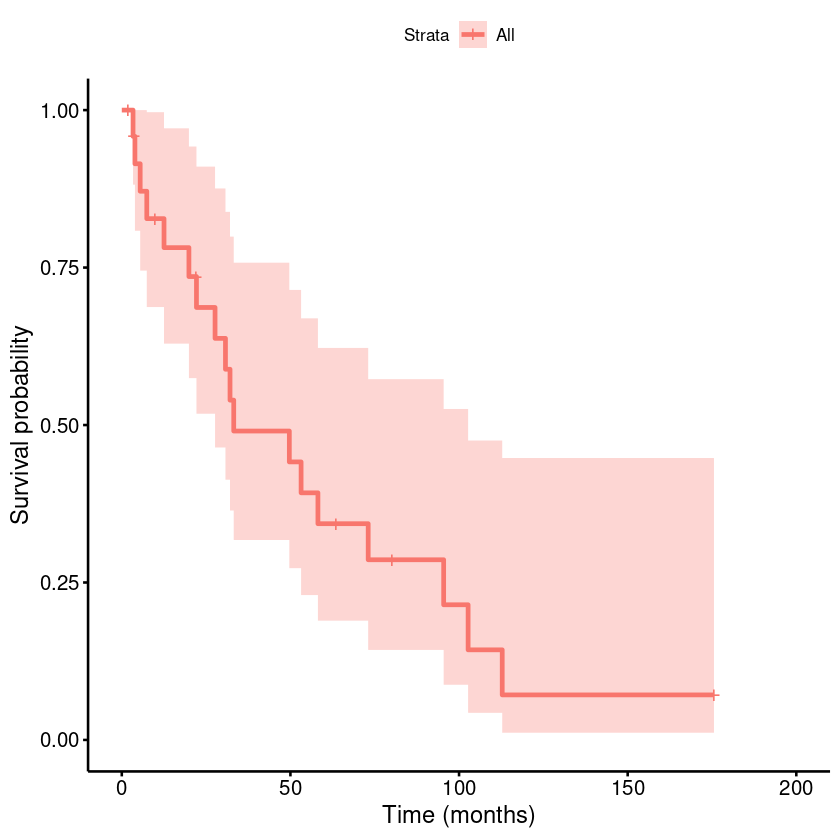

In [63]:
library(survminer)
library(survival)
fit <- survminer::surv_fit(survival::Surv(follow_time, status) ~ 1, data = pancreatic_cancer_survival)
survminer::ggsurvplot(fit, data = pancreatic_cancer_survival, xlab = "Time (months)")

### Extract HGB and age for all patients between the ages 60 and 70

Extract all Hemoglobin tests (HGB), age (in years) and sex for patients between the ages of 60 and 70:

In [64]:
emr_filter.create("age_60_70", "patients.dob", time.shift = c(-years(70), -years(60)))
hgb_60_70 <- emr_extract(c("age/year()", "lab.HGB", "sex"), iterator = "lab.HGB", filter = "age_60_70", names = c("age", "HGB", "sex"))

We can now plot the distribution: 



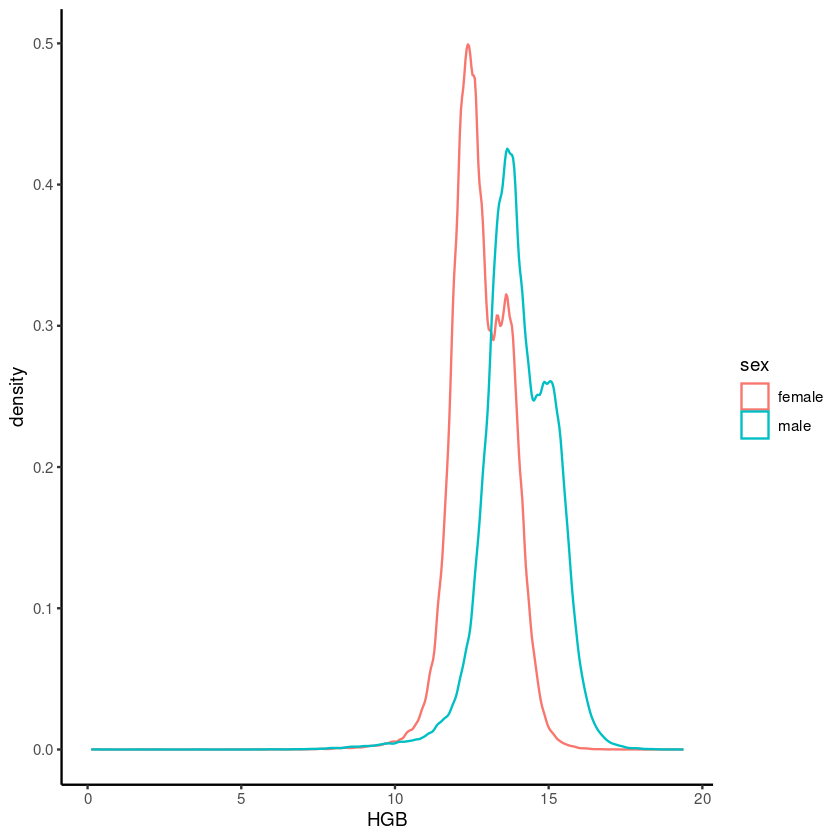

In [65]:
hgb_60_70 %>%
    mutate(sex = factor(c("male", "female")[sex])) %>%
    ggplot(aes(x = HGB, color = sex, group = sex)) +
    geom_density()

### Extract patients age at time of diagnosis of heart disease that did not have diabetes in the past

Extract patients age at the time of their first diagnosis of heart disease (diagnosis.411) that did not have diabetes (diagnosis.250) in the past.

This is very similar to the example above, in which we used a filter to exclude patients that had a previous diagnosis of heart disease. We are now going to use a slightly different approach that would first extract a the patient-time points of the heart disease onset and then use an additional query with these points as the iterator to filter out the patients that had diabetes in the past. This approach is useful in cases where we want to use the onset for other purposes, and it is convenient to have it in a separate table.

What would be our iterator? We can iterate the heart disease diagnosis track, and in many cases this would be the right choice. However, sometimes this track can be quite large, for example if it is a very common lab test. In such cases we can iterate over the “patients.dob” track instead, while shifting the time forward by the maximum amount (e.g. 120 years):

In [66]:
# Find onset of heart disease
emr_vtrack.create("heart_onset", "dx.icd9_411", time.shift = c(0, years(120)), func = "earliest.time")
emr_filter.create("has_heart_disease", "dx.icd9_411", time.shift = c(0, years(120)))

# Retreive the earliest time of heart disease for all patients in db that have a heart disease
heart_onset <- emr_extract("heart_onset", iterator = "patients.dob", filter = "has_heart_disease")
head(heart_onset)

,id,time,ref,heart_onset
,<int>,<int>,<int>,<dbl>
1,1,535998,-1,1220308
2,4,864871,-1,1280579
3,5,826123,-1,1306345
4,6,817547,-1,1259009
5,19,734365,-1,1322741
6,22,469544,-1,1227666


Now we can use the data frame we created as an iterator:



In [67]:
# filter patients that already have diabetes before heart disease
emr_filter.create("has_diabetes", "dx.icd9_585", time.shift = c(-years(120), 0))
heart_onset_no_diabetes <- emr_extract("age/year()", iterator = heart_onset %>% select(id, time = heart_onset), filter = "!has_diabetes", names = "age")

nrow(heart_onset)
nrow(heart_onset_no_diabetes)

head(heart_onset_no_diabetes)

[1] 25596

[1] 23584

,id,time,ref,age
,<int>,<int>,<int>,<dbl>
1,1,1220308,-1,78.11758
2,4,1280579,-1,47.45525
3,5,1306345,-1,54.81986
4,6,1259009,-1,50.39521
5,19,1322741,-1,67.16621
6,31,1229936,-1,69.97317


### Extract median Hemoglobin for all males between ages 60 to 70

Extract for each male patient the median Hemoglobin value between ages 60 and 70. 

Again we would use "patients.dob" as our iterator - this is very efficient as every patient would be examined only once, and define a virtual track with a time shift of 60 to 70 years with a function of median: 

In [68]:
emr_vtrack.create("median_hgb", "lab.HGB", time.shift = c(years(60), years(70)), func = "quantile", params = c(0.5))

Define a filter for males only: 



In [69]:
emr_filter.create("is_male", "patients.dob", val = 1)

Add another filter for having an HGB test in the relevant ages: 



In [70]:
emr_filter.create("has_hgb", "lab.HGB", time.shift = c(years(60), years(70)))

Extract median_hgb for males only:



In [71]:
male_hgb_60_70_q50 <- emr_extract("median_hgb", iterator = "patients.dob", filter = "is_male & has_hgb")

Compare with female median hgb:



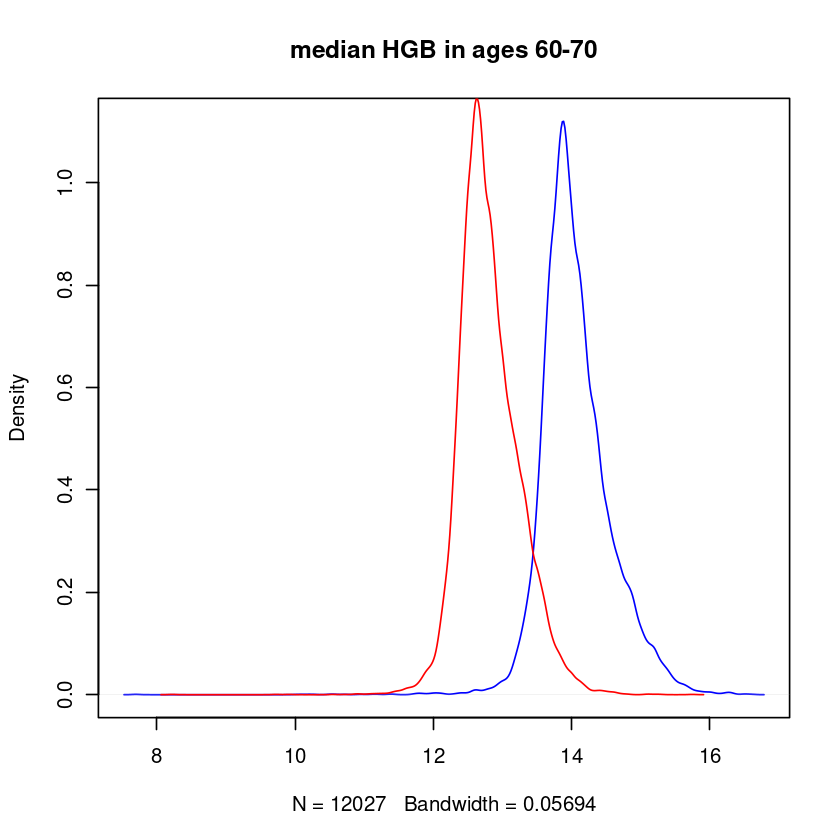

In [72]:
female_hgb_60_70_q50 <- emr_extract("median_hgb", iterator = "patients.dob", filter = "!is_male & has_hgb")
plot(density(male_hgb_60_70_q50$median_hgb, na.rm = TRUE), col = "blue", main = "median HGB in ages 60-70")
lines(density(female_hgb_60_70_q50$median_hgb, na.rm = TRUE), col = "red")

### Count number of patients by age that were in the system in January 2020

What does it mean to be "in the system"? Every EHR system would have its own definition of this, but in general - we want the patients that have already been born, have not died yet, have registered with the EHR system and haven't left the system (for good) yet.

We will start by creating a set of filters that will define the above conditions:

In [73]:
emr_filter.create("born", "patients.dob", time.shift = c(-years(120), 0))
emr_filter.create("dead", "patients.dod", time.shift = c(-years(120), 0))
emr_filter.create("registered", "patients.status.register", time.shift = c(-years(120), 0))
emr_filter.create("left_for_good", "patients.status.lfg", time.shift = c(-years(120), 0))

We can now use an iterator of a single point while applying all the filters to count the number of patients that were in the system in January 2020:



In [74]:
age_dist_2020 <- emr_dist("age/year()", 0:120, "sex", NULL,
    iterator = 1,
    stime = emr_date2time(1, 1, 2020),
    etime = emr_date2time(1, 1, 2020),
    filter = "born & !dead & registered & !left_for_good",
    names = c("age", "sex"),
    dataframe = TRUE,
    right = FALSE
)
head(age_dist_2020 %>% filter(n > 0))

,age,sex,n
,<fct>,<fct>,<dbl>
1,"[19,20)",1,38
2,"[20,21)",1,105
3,"[21,22)",1,176
4,"[22,23)",1,250
5,"[23,24)",1,370
6,"[24,25)",1,436


We can plot the distribution:



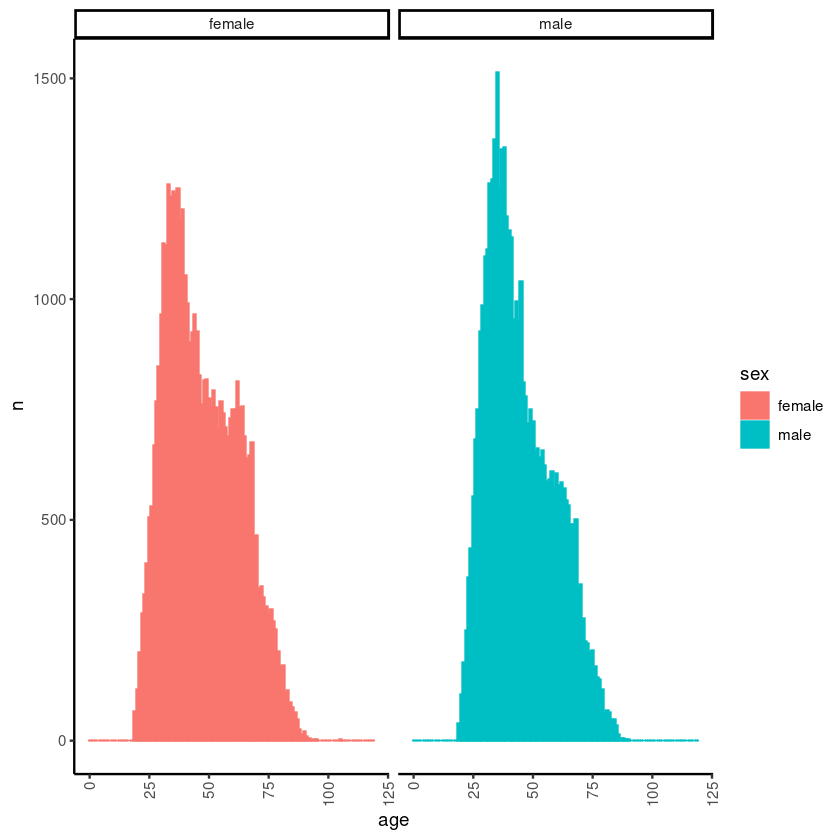

In [75]:
age_dist_2020 %>%
    mutate(sex = factor(c("male", "female")[sex])) %>%
    mutate(age = as.numeric(age) - 1) %>%
    ggplot(aes(x = age, y = n, colour = sex, fill = sex, group = sex)) +
    geom_col() +
    facet_wrap(~sex) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))